In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
from tqdm import tqdm
import pickle
import h5py

import numpy as np
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import jax.numpy as jnp

os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file("../matplotlibrc")

In [3]:
sys.path.append("..")
from estimates.config import wdir

## HERA

[]

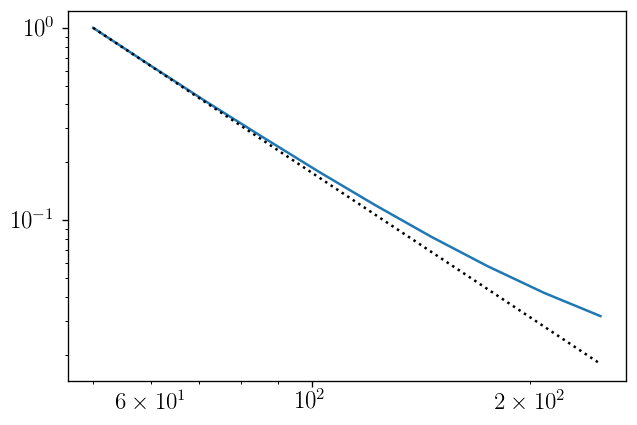

In [20]:
bkgs = []
freqs = np.geomspace(50, 250, 10)
for i in range(10):
    z = np.load(f"{wdir}/HERA-nnu10-nra1-ndec8/bkg/bkg-inu{i}-ira0-idec0.npy")
    bkgs.append(np.mean(z))
bkgs = np.array(bkgs) / bkgs[0]

plt.plot(freqs, bkgs)
plt.plot(freqs, (freqs/freqs[0])**(-2.5), 'k:')
plt.loglog()

[]

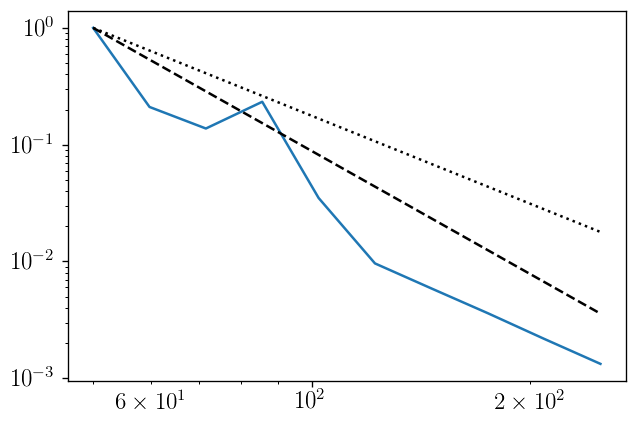

In [22]:
zs = []
freqs = np.geomspace(50, 250, 10)
for i in range(10):
    z = np.load(f"{wdir}/HERA-nnu10-nra1-ndec8/snr-fullinfo-base/snr-fullinfo-base-inu{i}-ira0-idec0.npy")
    zs.append(np.mean(z))
zs = np.array(zs) / zs[0]

plt.plot(freqs, zs)
plt.plot(freqs, (freqs/freqs[0])**(-2.5), 'k:')
plt.plot(freqs, (freqs/freqs[0])**(-3.5), 'k--')
plt.loglog()

## CHIME

[]

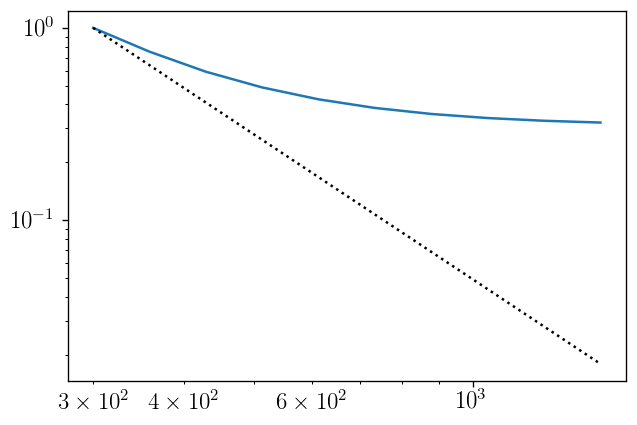

In [23]:
bkgs = []
freqs = np.geomspace(300, 1500, 10)
for i in range(10):
    z = np.load(f"{wdir}/CHORD-nnu10-nra1-ndec1/bkg/bkg-inu{i}-ira0-idec0.npy")
    bkgs.append(np.mean(z))
bkgs = np.array(bkgs) / bkgs[0]

plt.plot(freqs, bkgs)
plt.plot(freqs, (freqs/freqs[0])**(-2.5), 'k:')
plt.loglog()

[]

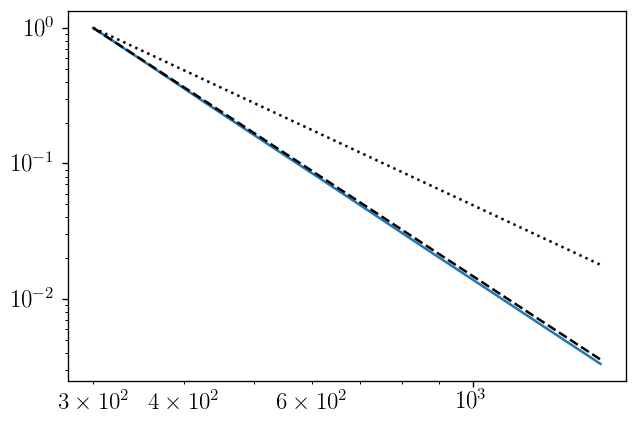

In [27]:
zs = []
freqs = np.geomspace(300, 1500, 10)
#freqs = np.geomspace(400, 800, 10)
for i in range(10):
    z = np.load(f"{wdir}/CHORD-nnu10-nra1-ndec1/snr-graveyard-base/snr-graveyard-base-inu{i}-ira0-idec0.npy")
    zs.append(np.mean(z))
zs = np.array(zs) / zs[0]

plt.plot(freqs, zs)
plt.plot(freqs, (freqs/freqs[0])**(-2.5), 'k:')
plt.plot(freqs, (freqs/freqs[0])**(-3.5), 'k--')
plt.loglog()

In [16]:
fn = '/n/holyscratch01/iaifi_lab/yitians/all_sky_gegenschein/axion-mirror/outputs/intermediates/HERA-nnu10-nra1-ndec8/egrs/egrs-inu0-ira0-idec1.npy'

In [17]:
z = np.load(fn)

In [18]:
np.min(z[z>0])

ValueError: zero-size array to reduction operation minimum which has no identity

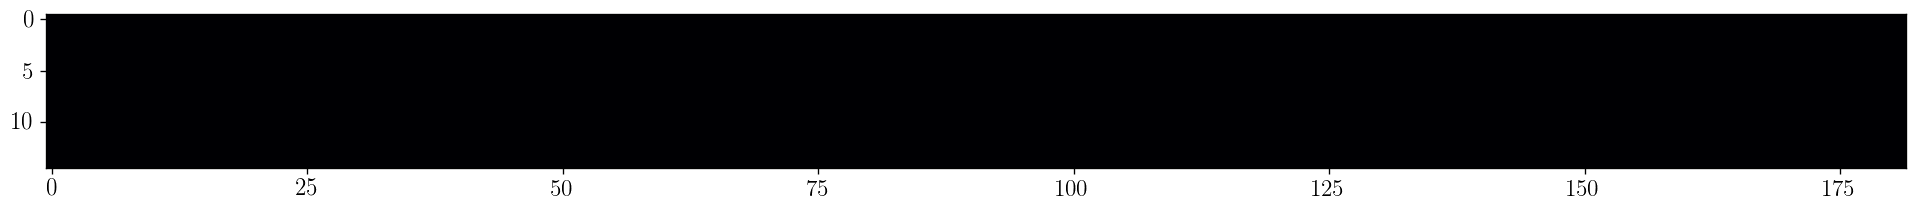

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.imshow(np.log(np.clip(z, 1e-10, None)), cmap='inferno')

In [20]:
sys.path.append("..")
from axionmirror import stats
# from axionmirror.units_constants import *
# from axionmirror.nfw import rho_integral, rho_integral_ref
# from axionmirror.spectral import dnu, prefac
# from axionmirror.map_utils import pad_mbl, interp2d_vmap

In [6]:
def pdf_func(x):
    return x**2

In [23]:
s = stats.sample_from_pdf(pdf_func, 0, 1, 100000)

In [8]:
rng_key = jax.random.PRNGKey(42)
start = 0.
end = 1.
num_samples = 10000
num_partition = 1000

In [9]:
x = jnp.linspace(start, end, num_partition)

In [12]:
pdf_func(x).shape

(1000,)

In [16]:
x[0]

Array(0., dtype=float32)

In [15]:
jnp.diff(x).shape

(999,)

In [17]:
cdf = jnp.cumsum(pdf_func(x) * jnp.diff(x, prepend=x[0].item()))

In [19]:
cdf.shape

(1000,)

In [25]:
%timeit stats.sample_from_pdf_jax(rng_key, pdf_func, 0., 1., 100000)

2.28 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit stats.sample_from_pdf(pdf_func, 0, 1, 100000)

7.29 ms ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
import jax
rng_key = jax.random.PRNGKey(42)
s2 = stats.sample_from_pdf_jax(rng_key, pdf_func, 0., 1., 100000)

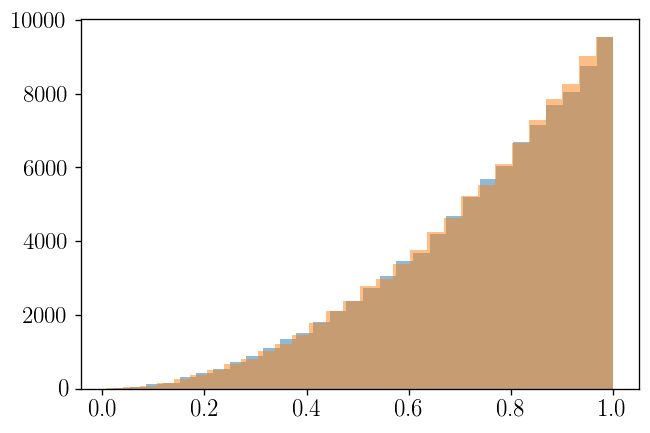

In [24]:
plt.hist(s, bins=30, alpha=0.5);
plt.hist(s2, bins=30, alpha=0.5);


In [2]:
c = SkyCoord(l=76.18988064623*u.deg, b=5.75538801499*u.deg, frame="galactic")
c.icrs.ra, c.icrs.dec

(<Longitude 299.86815237 deg>, <Latitude 40.7339159 deg>)

In [4]:
l = 76.18988064623 * u.deg

In [10]:
z = np.loadtxt('../data/egrs/cygA_spec.txt')

[]

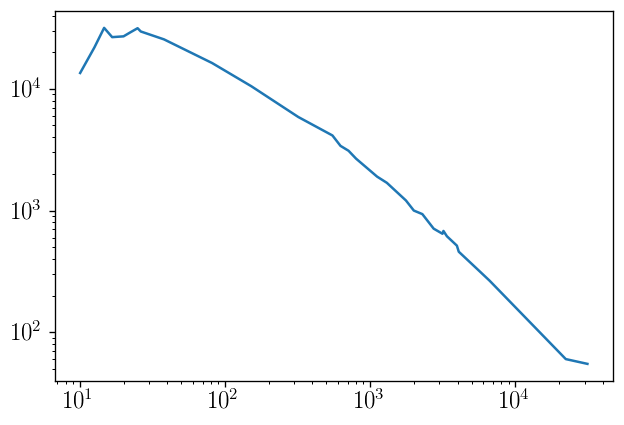

In [12]:
plt.plot(z[:,0], z[:,1])
plt.loglog()

In [ ]:
l = 76.18988064623
b = 05.75538801499

In [21]:
coord_GC = SkyCoord(l=0*u.rad, b=0*u.rad, frame='galactic')
ra_GC = coord_GC.icrs.ra.rad
dec_GC = coord_GC.icrs.dec.rad
ra_antiGC = ra_GC - np.pi
dec_antiGC = - dec_GC

In [25]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [26]:
np.searchsorted?

Signature: np.searchsorted(a, v, side='left', sorter=None)
Docstring:
Find indices where elements should be inserted to maintain order.

Find the indices into a sorted array `a` such that, if the
corresponding elements in `v` were inserted before the indices, the
order of `a` would be preserved.

Assuming that `a` is sorted:

======  ============================
`side`  returned index `i` satisfies
======  ============================
left    ``a[i-1] < v <= a[i]``
right   ``a[i-1] <= v < a[i]``
======  ============================

Parameters
----------
a : 1-D array_like
    Input array. If `sorter` is None, then it must be sorted in
    ascending order, otherwise `sorter` must be an array of indices
    that sort it.
v : array_like
    Values to insert into `a`.
side : {'left', 'right'}, optional
    If 'left', the index of the first suitable location found is given.
    If 'right', return the last such index.  If there is no suitable
    index, return either 0 or N (where N is the 

In [32]:
np.searchsorted(np.arange(10), -9)

0

In [ ]:
ra_s  = np.linspace(0.01, 2*np.pi, 300)
dec_s = np.linspace(np.deg2rad(20), np.pi/2, 300)
ra_grid, dec_grid = np.meshgrid(ra_s, dec_s)
radec_flat = np.stack([ra_grid.ravel(), dec_grid.ravel()], axis=-1)
radec_shape = (len(dec_s), len(ra_s))

coord_grid = SkyCoord(ra=ra_grid*u.rad, dec=dec_grid*u.rad, frame='icrs')
l_grid = np.array(coord_grid.galactic.l.rad)
b_grid = np.array(coord_grid.galactic.b.rad)

l_grid = np.where(l_grid > np.pi, l_grid-2*np.pi, l_grid)
bl_flat = np.stack([b_grid.ravel(), l_grid.ravel()], axis=-1)

In [18]:
with h5py.File("../outputs/gsr/Tf_408MHz_fieldJF.h5", 'r') as hf:
    pm, pb, pl = pad_mbl(hf['Tf'][:], hf['b_s'][:], hf['l_s'][:])

In [78]:
sig_flat = interp2d_vmap(pm, pb, pl, bl_flat)
sig = sig_flat.reshape(radec_shape)

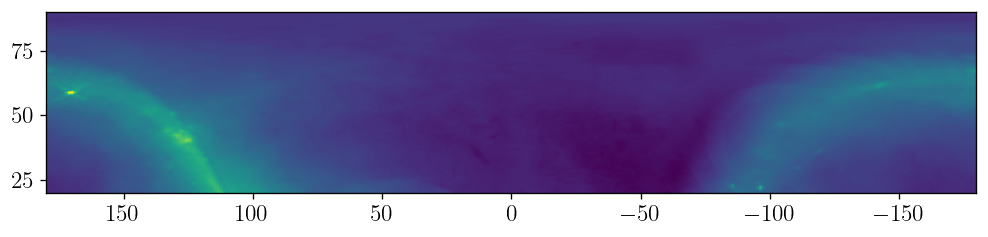

In [80]:
fig, ax = plt.subplots(figsize=(10., 5))
ax.imshow(np.flip(np.log(sig)), extent=(180, -180, 20, 90));